# Agent를 이용한 Self Corrective RAG

https://github.com/kyopark2014/llm-agent/blob/main/self-corrective-rag.md

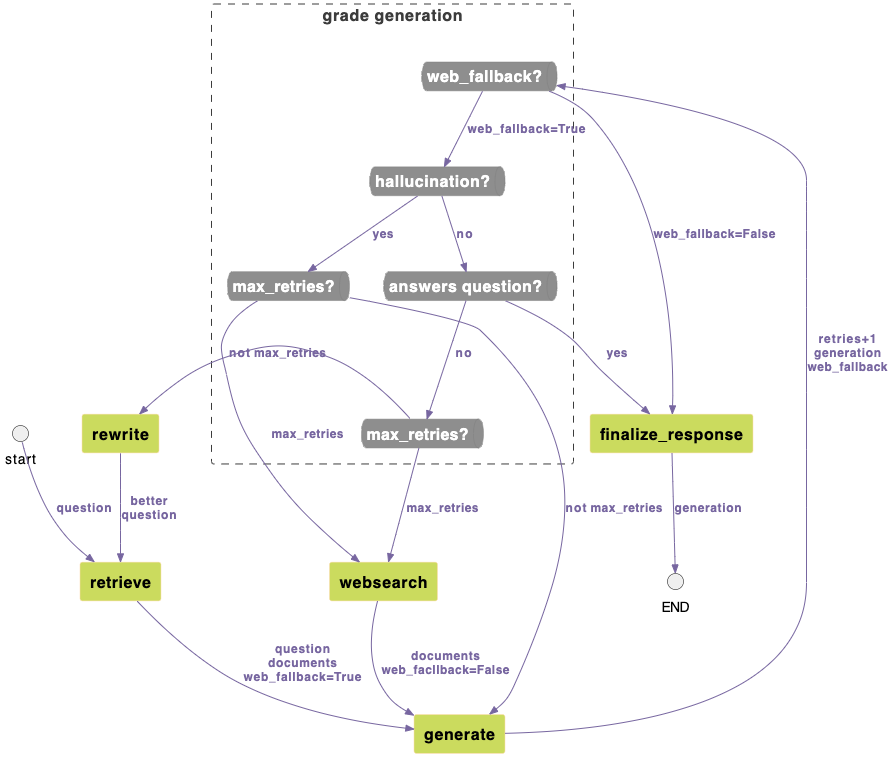

In [1]:
import boto3

In [3]:
!pip3 install langchain-aws langchain-community langchain --quiet

In [4]:
from botocore.config import Config
from langchain_aws import ChatBedrock
bedrock_region = 'us-east-1'
modelId = "anthropic.claude-3-sonnet-20240229-v1:0"
boto3_bedrock = boto3.client(
    service_name='bedrock-runtime',
    region_name=bedrock_region,
    config=Config(
        retries = {
            'max_attempts': 30
        }            
    )
)

HUMAN_PROMPT = "\n\nHuman:"
AI_PROMPT = "\n\nAssistant:"
maxOutputTokens = 4096
parameters = {
    "max_tokens":maxOutputTokens,     
    "temperature":0.1,
    "top_k":250,
    "top_p":0.9,
    "stop_sequences": [HUMAN_PROMPT]
}    
chat = ChatBedrock(   
    model_id=modelId,
    client=boto3_bedrock, 
    model_kwargs=parameters,
)

from langchain_community.embeddings import BedrockEmbeddings
embedding_model_id = "amazon.titan-embed-text-v2:0"
bedrock_embedding = BedrockEmbeddings(
    client=boto3_bedrock,
    region_name = bedrock_region,
    model_id = embedding_model_id
) 

In [5]:
from langchain.memory import ConversationBufferWindowMemory
memory_chain = ConversationBufferWindowMemory(memory_key="chat_history", output_key='answer', return_messages=True, k=10)

## Tavily Search

In [6]:
import getpass

api_key = getpass.getpass("Password:")

Password: ········


In [7]:
import os
os.environ["TAVILY_API_KEY"] = api_key

In [8]:
!pip install -U tavily-python --quiet

In [9]:
langsmith_api_key = getpass.getpass("Password:")

Password: ········


In [10]:
os.environ["LANGCHAIN_API_KEY"] = langsmith_api_key
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Self-Corrective-RAG"

In [12]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt = ChatPromptTemplate.from_messages(
    [
        ("system",
            "다음의 Human과 Assistant의 친근한 이전 대화입니다."
            "Assistant은 상황에 맞는 구체적인 세부 정보를 충분히 제공합니다."
            "Assistant의 이름은 서연이고, 모르는 질문을 받으면 솔직히 모른다고 말합니다.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
chain = prompt | chat

msg = ""
request = HumanMessage(
    content="이미지를 분석하기 위한 서비스에 대해 설명해줘."
)

output = chain.stream({"messages": [request]})
for event in output:
    print(event.content, end="")
    msg += event.content
    
msg

안녕하세요. 이미지 분석 서비스에 대해 설명해 드리겠습니다. 이미지 분석 서비스는 컴퓨터 비전과 머신러닝 기술을 활용하여 이미지에서 다양한 정보를 추출하고 분석하는 서비스입니다. 

주요 기능으로는 객체 인식, 얼굴 인식, 텍스트 인식, 이미지 분류, 콘텐츠 모더레이션 등이 있습니다. 객체 인식은 이미지 내에 있는 사물이나 사람 등의 객체를 인식하고 분류합니다. 얼굴 인식은 이미지에서 사람의 얼굴을 찾아내고 연령, 감정 등의 속성을 분석합니다.

텍스트 인식은 이미지 내 텍스트 영역을 찾아 텍스트를 추출합니다. 이미지 분류는 이미지의 전체적인 내용을 분류하고 레이블을 붙입니다. 콘텐츠 모더레이션은 부적절한 콘텐츠를 검출하는 기능입니다.

이런 기능들을 활용하면 이미지에서 유용한 정보를 자동으로 추출할 수 있어 다양한 분야에서 활용될 수 있습니다. 제가 더 자세히 설명드릴 부분이 있다면 말씀해주세요.

'안녕하세요. 이미지 분석 서비스에 대해 설명해 드리겠습니다. 이미지 분석 서비스는 컴퓨터 비전과 머신러닝 기술을 활용하여 이미지에서 다양한 정보를 추출하고 분석하는 서비스입니다. \n\n주요 기능으로는 객체 인식, 얼굴 인식, 텍스트 인식, 이미지 분류, 콘텐츠 모더레이션 등이 있습니다. 객체 인식은 이미지 내에 있는 사물이나 사람 등의 객체를 인식하고 분류합니다. 얼굴 인식은 이미지에서 사람의 얼굴을 찾아내고 연령, 감정 등의 속성을 분석합니다.\n\n텍스트 인식은 이미지 내 텍스트 영역을 찾아 텍스트를 추출합니다. 이미지 분류는 이미지의 전체적인 내용을 분류하고 레이블을 붙입니다. 콘텐츠 모더레이션은 부적절한 콘텐츠를 검출하는 기능입니다.\n\n이런 기능들을 활용하면 이미지에서 유용한 정보를 자동으로 추출할 수 있어 다양한 분야에서 활용될 수 있습니다. 제가 더 자세히 설명드릴 부분이 있다면 말씀해주세요.'

In [13]:
!pip install faiss-cpu --quiet

In [14]:
# English URL
urls = [
    "https://aws.amazon.com/ko/blogs/tech/image-recommender-based-on-emotion/",
    "https://docs.aws.amazon.com/ko_kr/rekognition/latest/dg/what-is.html",
    "https://docs.aws.amazon.com/ko_kr/textract/latest/dg/what-is.html",
    "https://docs.aws.amazon.com/ko_kr/bedrock/latest/userguide/what-is-bedrock.html",
    "https://docs.aws.amazon.com/ko_kr/athena/latest/ug/what-is.html",
    "https://docs.aws.amazon.com/ko_kr/athena/latest/ug/glue-athena.html"
]

In [15]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores.faiss import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [16]:
doc_splits[0]

Document(metadata={'source': 'https://aws.amazon.com/ko/blogs/tech/image-recommender-based-on-emotion/', 'title': 'Amazon Rekognition과 Personalize를 이용하여 감정으로 이미지 추천하기 | AWS 기술 블로그', 'language': 'ko-KR'}, page_content='Amazon Rekognition과 Personalize를 이용하여 감정으로 이미지 추천하기 | AWS 기술 블로그\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n Skip to Main Content\n\n\n\n\n\nAmazon Web Services 홈 페이지로 돌아가려면 여기를 클릭하십시오.\n\n\n\n문의하기\n 지원\xa0 \n고객지원\n한국어\xa0\n내 계정\xa0\n\n\n\n\n 로그인\n\n\n  AWS 계정 생성 \n\n\n\n\n\n\n\n\n\nre:Invent\n제품\n솔루션\n요금\n설명서\n학습하기\n파트너 네트워크\nAWS Marketplace\n고객 지원\n이벤트\n자세히 알아보기 \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n 닫기 \n\n\n\nعربي\nBahasa Indonesia\nDeutsch\nEnglish\nEspañol\nFrançais\nItaliano\nPortuguês\n\n\n\n\nTiếng Việt\nTürkçe\nΡусский\nไทย\n日本語\n한국어\n中文 (简体)\n中文 (繁體)\n\n\n\n\n\n 닫기 \n\n내 프로필\nAWS Builder ID에서 로그아웃\nAWS Management Console\n계정 설정\n결제 및 비용 관리\n보안 자격 증명\nAWS Personal Health Dashboard\n\n\n\n 닫기 \n\n지원 센터\n

In [17]:
# Add to vectorDB
vectorstore = FAISS.from_documents(
    doc_splits,
    bedrock_embedding,
)
retriever = vectorstore.as_retriever()

In [18]:
from langchain_core.pydantic_v1 import BaseModel, Field

class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(description="Documents are relevant to the question, 'yes' or 'no'")

structured_llm_grader = chat.with_structured_output(GradeDocuments)

In [19]:
# Prompt 
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

In [20]:
retrieval_grader = grade_prompt | structured_llm_grader
question = "이미지를 분석하기 위한 서비스에 대해 설명해줘."
docs = retriever.invoke(question)

In [21]:
doc_txt = docs[1].page_content
doc_txt

'물체, 장면, 개념 감지 - 이미지에서 사물, 장면, 개념, 유명인을 감지하고 분류합니다.\n\n텍스트 감지 - 다양한 언어로 된 이미지에서 인쇄된 텍스트와 손으로 쓴 텍스트를 감지하고 인식합니다.\n\n안전하지 않은 콘텐츠 - 노골적이거나 부적절하고 폭력적인 콘텐츠와 이미지를 탐지하고 필터링합니다. 세분화된 안전하지 않은 콘텐츠 라벨을 탐지합니다.\n\n유명인 인식 - 정치인, 운동선수, 배우, 음악가 등 다양한 카테고리의 이미지 속 수만 명의 유명인을 인식합니다.\n\n얼굴 분석 - 성별, 나이, 감정 등의 얼굴 특성과 함께 얼굴을 감지, 분석 및 비교합니다. 사용 사례에는 사용자 확인, 카탈로그 작성, 인원 수 계산, 공공 안전 등이 포함될 수 있습니다.\n\n사용자 지정 레이블 - 사용자 지정 분류기를 만들어 로고, 제품, 문자 등 사용 사례에 맞는 개체를 탐지할 수 있습니다.\n\n이미지 속성 - 품질, 색상, 선명도, 대비와 같은 이미지 속성을 분석합니다.\n\n 비디오 분석:'

In [22]:
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'


### RAG Prompt

In [23]:
system = (
#"""Here is pieces of context, contained in <context> tags. Provide a concise answer to the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.
"""다음의 <context> tag안의 참고자료를 이용하여 상황에 맞는 구체적인 세부 정보를 충분히 제공합니다. Assistant의 이름은 서연이고, 모르는 질문을 받으면 솔직히 모른다고 말합니다.
                        
<context>
{context}
</context>""")
human = "{question}"
    
prompt = ChatPromptTemplate.from_messages([("system", system), ("human", human)])
                   
rag_chain = prompt | chat

In [24]:
# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

content='네, Amazon Rekognition은 딥러닝 기술을 활용한 이미지 및 비디오 분석 서비스입니다. 주요 기능에 대해 설명드리겠습니다.\n\n1. 물체, 장면, 개념 감지: 이미지에서 사물, 장면, 개념, 유명인을 감지하고 분류할 수 있습니다.\n\n2. 텍스트 감지: 다양한 언어로 된 이미지에서 인쇄된 텍스트와 손으로 쓴 텍스트를 감지하고 인식합니다.\n\n3. 안전하지 않은 콘텐츠 탐지: 노골적이거나 부적절하고 폭력적인 콘텐츠와 이미지를 탐지하고 필터링할 수 있습니다.\n\n4. 유명인 인식: 정치인, 운동선수, 배우, 음악가 등 다양한 분야의 유명인을 인식합니다.\n\n5. 얼굴 분석: 성별, 나이, 감정 등의 얼굴 특성을 분석하고 얼굴을 감지 및 비교할 수 있습니다.\n\n6. 사용자 지정 레이블: 로고, 제품, 문자 등 사용자 지정 분류기를 만들어 원하는 객체를 탐지할 수 있습니다.\n\n7. 이미지 속성 분석: 품질, 색상, 선명도, 대비 등의 이미지 속성을 분석합니다.\n\nAmazon Rekognition은 AWS 서비스와 통합되어 있고 확장성과 보안을 제공하며 사용한 만큼만 비용을 지불하는 방식으로 운영됩니다.' additional_kwargs={'usage': {'prompt_tokens': 2104, 'completion_tokens': 561, 'total_tokens': 2665}, 'stop_reason': 'end_turn', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'} response_metadata={'usage': {'prompt_tokens': 2104, 'completion_tokens': 561, 'total_tokens': 2665}, 'stop_reason': 'end_turn', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'} id='run-86f84478-4638-40e9-b461-0949f54a2

### ReWrite Prompt

In [25]:
class RewriteQuestion(BaseModel):
    """rewrited question that is well optimized for retrieval."""

    question: str = Field(description="The new question is optimized for web search")
    
structured_llm_rewriter = chat.with_structured_output(RewriteQuestion)

In [26]:
# Prompt 
#system = """You a question re-writer that converts an input question to a better version that is optimized \n 
#     for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""
system = """당신은 웹 검색에 최적화된 더 나은 버전의 Question으로 변환하는 질문 re-writer입니다. 질문의 의도와 의미을 잘 표현할 수 있는 한국어 질문을 생성하세요."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Question: {question}"),
    ]
)

In [27]:
question_rewriter = re_write_prompt | structured_llm_rewriter
question = "이미지를 분석하기 위한 서비스에 대해 설명해줘."
print(question_rewriter.invoke({"question": question}))

question='이미지 분석 서비스에 대한 정보'


### Hallucination Prompt

In [28]:
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )

structured_llm_grade_hallucination = chat.with_structured_output(GradeHallucinations)

In [29]:
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grade_hallucination
hallucination_grader.invoke({"documents": docs, "generation": generation.content})

GradeHallucinations(binary_score='yes')

## Answer Grader

In [30]:
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )
structured_llm_grade_answer = chat.with_structured_output(GradeAnswer)

In [31]:
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)
answer_grader = answer_prompt | structured_llm_grade_answer
answer_grader.invoke({"question": question, "generation": generation.content})

GradeAnswer(binary_score='yes')

### Graph State

In [32]:
from typing import Annotated, Iterator, Literal, TypedDict
from langgraph.graph import END, StateGraph, add_messages
from langchain_core.documents import Document

class GraphState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    question: str
    documents: list[Document]
    candidate_answer: str
    retries: int
    web_fallback: bool

class GraphConfig(TypedDict):
    max_retries: int

In [33]:
MAX_RETRIES = 3

In [34]:
from langchain.schema import Document

def retrieve(state: GraphState):
    print("###### retrieve ######")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    print("len(document): ", len(documents))
    
    return {"documents": documents, "question": question, "web_fallback": True}

In [35]:
def generate(state: GraphState):
    print("###### generate ######")
    question = state["question"]
    documents = state["documents"]
    retries = state["retries"] if state.get("retries") is not None else -1
    
    # RAG generation
    generation = rag_chain.invoke({"context": docs, "question": question})
    print('generation: ', generation.content)
    
    #return {"documents": documents, "question": question, "generation": generation, "web_fallback": True}
    return {"retries": retries + 1, "candidate_answer": generation.content}

In [36]:
def rewrite(state: GraphState):
    print("###### rewrite ######")
    question = state["question"]
    documents = state["documents"]

    # Prompt
    better_question = question_rewriter.invoke({"question": question})
    print("better_question: ", better_question.question)

    return {"question": better_question.question, "documents": documents}

In [37]:
def grade_generation(state: GraphState, config):
    question = state["question"]
    documents = state["documents"]
    generation = state["candidate_answer"]
    web_fallback = state["web_fallback"]
    
    retries = state["retries"] if state.get("retries") is not None else -1
    max_retries = config.get("configurable", {}).get("max_retries", MAX_RETRIES)

    # this means we've already gone through web fallback and can return to the user
    if not web_fallback:
        return "finalize_response"

    print("---Hallucination?---")
        
    hallucination_grade = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    print("hallucination_grade: ", hallucination_grade)
    print("retries: ", retries)

    # Check hallucination
    if hallucination_grade.binary_score == "no":
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "generate" if retries < max_retries else "websearch"

    print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
    print("---GRADE GENERATION vs QUESTION---")

    # Check question-answering
    answer_grade = answer_grader.invoke({"question": question, "generation": generation})
    print("answer_grade: ", answer_grade)
    if answer_grade.binary_score == "yes":
        print("---DECISION: GENERATION ADDRESSES QUESTION---")
        return "finalize_response"
    else:
        print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
        return "rewrite" if retries < max_retries else "websearch"

## Web Search Tool

In [38]:
from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults(k=3)

In [39]:
def web_search(state: GraphState):
    print("###### web_search ######")
    question = state["question"]
    documents = state["documents"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    print("web_results: ", web_results)
    
    if documents is not None:
        documents.append(web_results)
    else:
        documents = [web_results]
    
    return {"documents": documents, "web_fallback": False}

In [40]:
def finalize_response(state: GraphState):
    return {"messages": [AIMessage(content=state["candidate_answer"])]}

## Workflow

In [41]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  
workflow.add_node("generate", generate) 
workflow.add_node("rewrite", rewrite)
workflow.add_node("websearch", web_search)
workflow.add_node("finalize_response", finalize_response)

# Build graph
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "generate")
workflow.add_edge("rewrite", "retrieve")
workflow.add_edge("websearch", "generate")
workflow.add_edge("finalize_response", END)

workflow.add_conditional_edges(
    "generate",
    grade_generation,
    {
        "generate": "generate",
        "websearch": "websearch",
        "rewrite": "rewrite",
        "finalize_response": "finalize_response",
    },
)

# Compile
app = workflow.compile()

### Build Graph

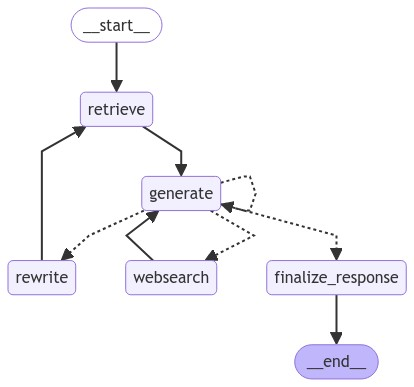

In [42]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [43]:
from pprint import pprint
inputs = {"question": "이미지를 분석하기 위한 서비스에 대해 설명해줘."}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value)

###### retrieve ######
len(document):  4
'Finished running: retrieve:'
###### generate ######
generation:  네, Amazon Rekognition은 이미지와 동영상을 분석하기 위한 딥 러닝 기반의 서비스입니다. 주요 기능은 다음과 같습니다.

1. 물체, 장면, 개념 감지: 이미지에서 사물, 장면, 개념, 유명인을 감지하고 분류합니다.

2. 텍스트 감지: 다양한 언어로 된 이미지에서 인쇄된 텍스트와 손으로 쓴 텍스트를 감지하고 인식합니다.

3. 안전하지 않은 콘텐츠 감지: 노골적이거나 부적절하고 폭력적인 콘텐츠와 이미지를 탐지하고 필터링합니다.

4. 유명인 인식: 정치인, 운동선수, 배우, 음악가 등 다양한 분야의 유명인을 인식합니다. 

5. 얼굴 분석: 성별, 나이, 감정 등의 얼굴 특성을 분석하고 얼굴을 감지 및 비교합니다.

6. 사용자 지정 레이블: 로고, 제품, 문자 등 사용자 지정 분류기를 만들어 개체를 탐지할 수 있습니다.

7. 이미지 속성 분석: 품질, 색상, 선명도, 대비 등의 이미지 속성을 분석합니다.

Amazon Rekognition은 AWS 서비스와 통합되어 있고 확장성과 보안을 갖추고 있으며, 사용한 만큼만 비용을 지불하는 저렴한 가격 정책을 가지고 있습니다.
---Hallucination?---
hallucination_grade:  binary_score='yes'
retries:  0
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
answer_grade:  binary_score='yes'
---DECISION: GENERATION ADDRESSES QUESTION---
'Finished running: generate:'
'Finished running: finalize_response:'
{'messages': [AIMessag

In [44]:
inputs = {"question": "How does the AlphaCodium paper work?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value)

###### retrieve ######
len(document):  4
'Finished running: retrieve:'
###### generate ######
generation:  죄송합니다. 제가 AlphaCodium 논문에 대해서는 잘 모르겠습니다. 제공된 컨텍스트 정보에는 Amazon Rekognition 서비스에 대한 설명만 있고 AlphaCodium에 대한 내용은 없습니다. 이 주제에 대해서는 모른다고 말씀드려야 겠습니다.
---Hallucination?---
hallucination_grade:  binary_score='no'
retries:  0
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---
'Finished running: generate:'
###### generate ######
generation:  죄송합니다. 제가 AlphaCodium 논문에 대해 잘 모르겠습니다. 제공된 컨텍스트 정보에는 Amazon Rekognition 서비스에 대한 설명만 있고 AlphaCodium 논문에 대한 내용은 없습니다. 이 주제에 대해서는 더 자세히 설명해 드릴 수 없습니다.
---Hallucination?---
hallucination_grade:  binary_score='no'
retries:  1
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---
'Finished running: generate:'
###### generate ######
generation:  죄송합니다. 제가 AlphaCodium 논문에 대해 잘 모르겠습니다. 제공된 컨텍스트 정보에는 Amazon Rekognition 서비스에 대한 설명만 있고 AlphaCodium 논문에 대한 내용은 없습니다. 이 주제에 대해서는 더 자세히 설명해 드릴 수 없습니다.
---Hallucination?---
hallucination_grade:  binar

In [45]:
inputs = {"question": "Aver의 Glue는 무엇이지?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value)

###### retrieve ######
len(document):  4
'Finished running: retrieve:'
###### generate ######
generation:  죄송합니다. 제가 알고 있는 정보 내에서는 'Aver의 Glue'가 무엇인지 모르겠습니다. Amazon Rekognition 서비스에 대한 설명은 있지만 'Aver의 Glue'에 대해서는 언급된 내용이 없습니다. 이 주제에 대해 더 자세히 알고 싶으시다면 추가 정보를 제공해 주시면 감사하겠습니다.
---Hallucination?---
hallucination_grade:  binary_score='no'
retries:  0
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---
'Finished running: generate:'
###### generate ######
generation:  죄송합니다. 제가 알고 있는 정보 내에서는 'Aver의 Glue'가 무엇인지 모르겠습니다. Amazon Rekognition 서비스에 대한 설명은 있지만 'Aver의 Glue'에 대해서는 언급된 내용이 없습니다. 이 주제에 대해 더 자세히 알고 싶으시다면 추가 정보를 제공해 주시면 감사하겠습니다.
---Hallucination?---
hallucination_grade:  binary_score='no'
retries:  1
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---
'Finished running: generate:'
###### generate ######
generation:  죄송합니다. 제가 알고 있는 정보 내에서는 'Aver의 Glue'가 무엇인지 모르겠습니다. Amazon Rekognition 서비스에 대한 설명은 있지만 'Aver의 Glue'에 대해서는 언급된 내용이 없습니다. 이 주제에 대해 더 자세히 알고 싶으시다면 추가 정보를 제공해